# Code for Batch Trajectory Alignment and Similarity Metrics

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from ipywidgets import *

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [2]:
from nah.loader import load_raw_csv_data, load_npzs
from nah.utils import norm_data, full_align,clean_rot_data, segment_by_demo, sum_of_squares
from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data, plot_heatmap, plot_correlation_matrix
from nah.datagraphs import generate_self_similarity_heat_map, hand_range, study_range_vals, generate_all_cross_correlation_matrix, generate_pairwise_comparison

from evo.core.trajectory import PoseTrajectory3D
from nah.trajectory import get_evo_trajectory, get_evo_metrics, evo_sync, convert_evo_to_np, evaluate_ape
from nah.alignments import evo_align, Alignment

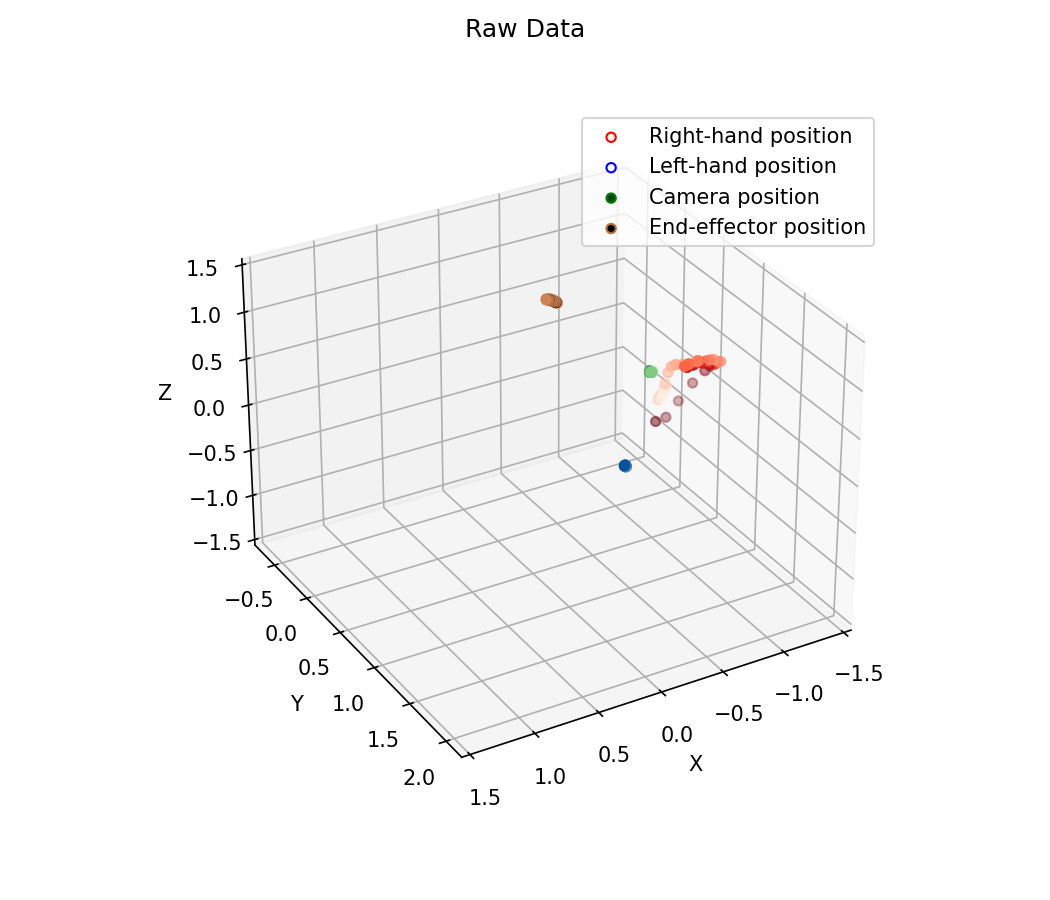

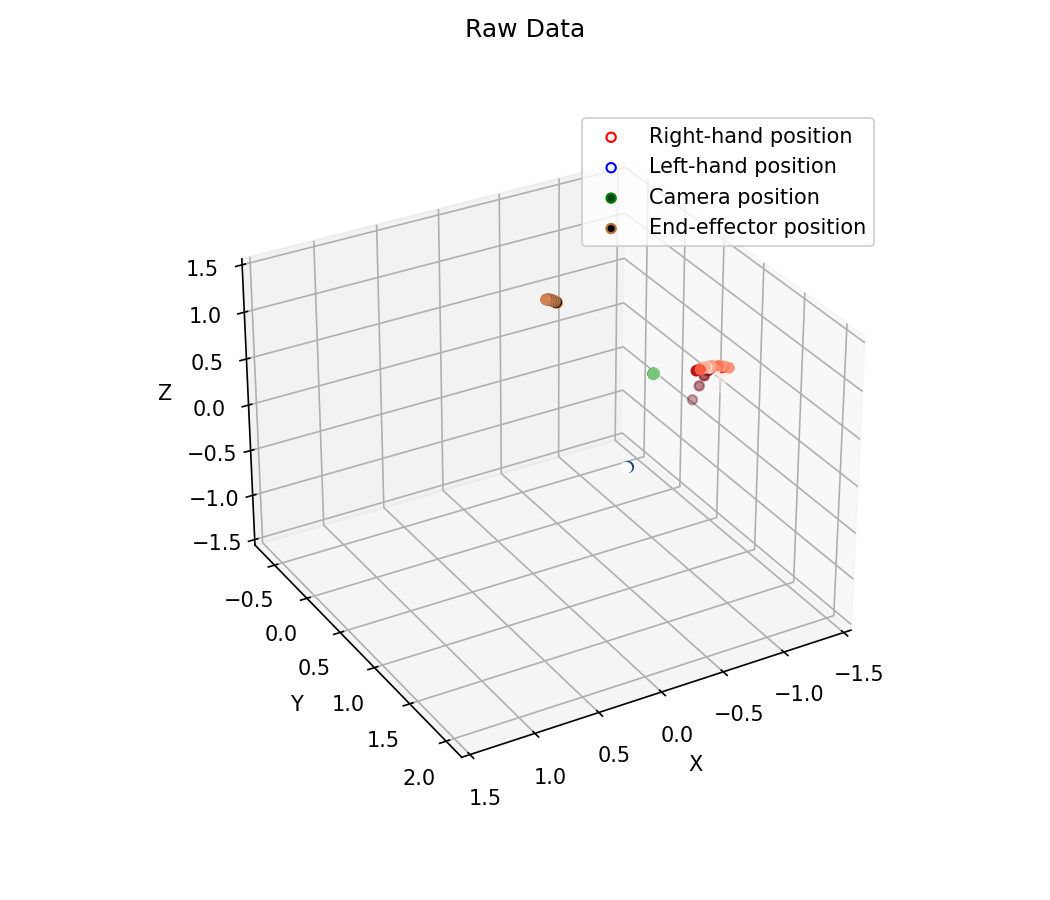

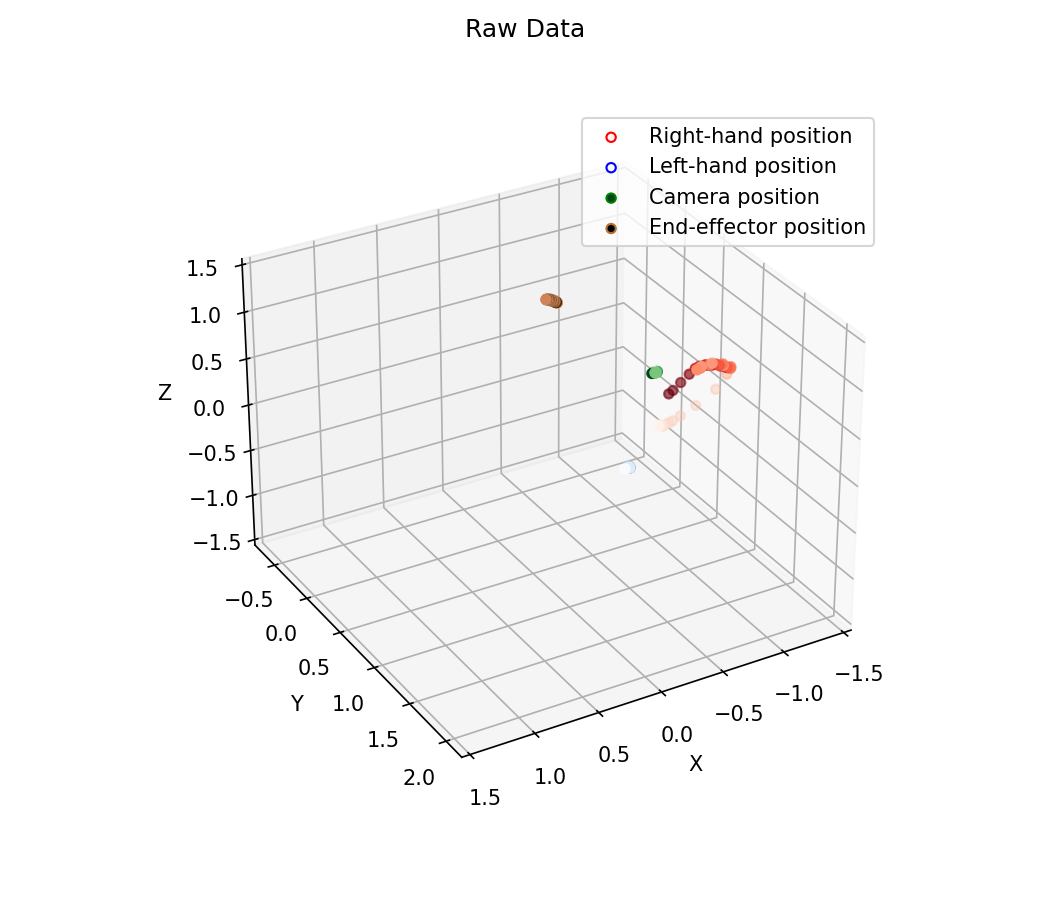

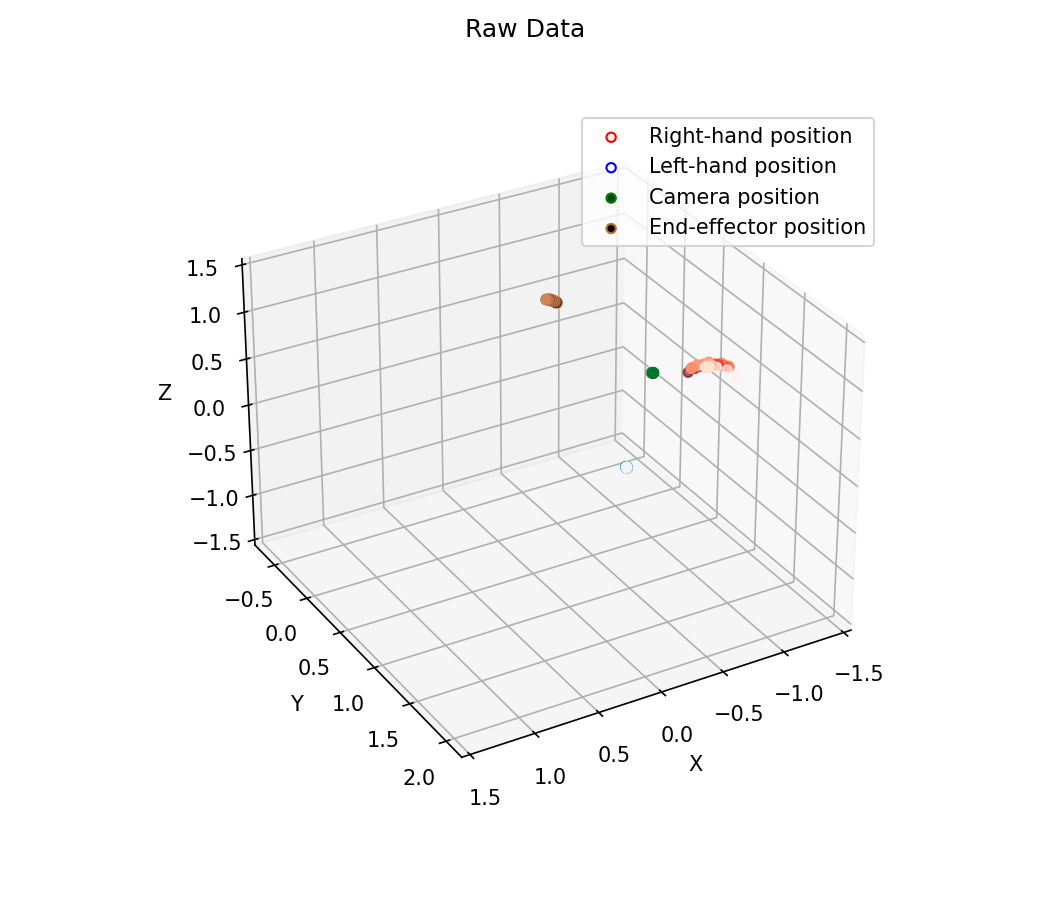

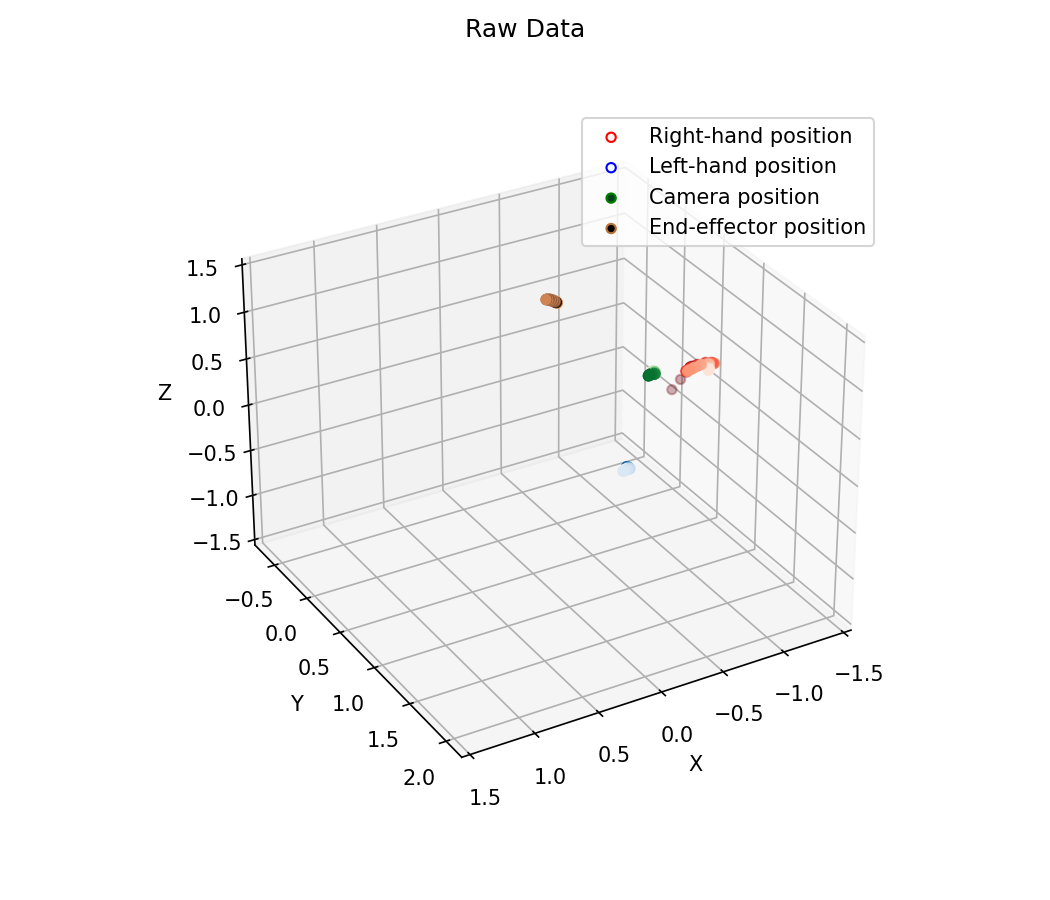

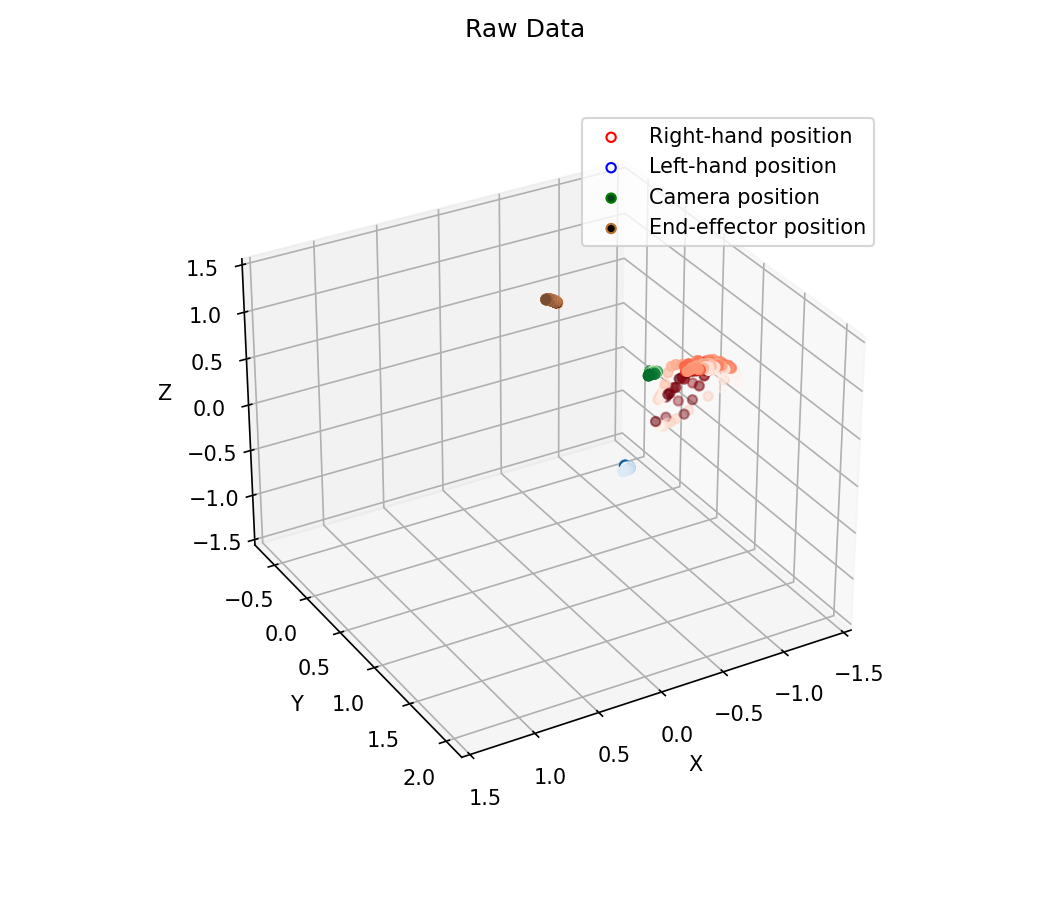

In [14]:
%matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

# robot_name='j2s6s300'
robot_name='Reachy'
gesture_num=1


total_end_eff = np.array([])
total_camera  = np.array([])
total_rh      = np.array([])
total_lh      = np.array([])
total_joint   = np.array([])

singlePID=True
singlePIDval = 7
followup = True

if singlePID:
    PID_begin_range=singlePIDval
    PID_end_range=singlePIDval+1 #Don't forget to +1 to whatever your last PID is
else:
    PID_begin_range=1
    if followup:
        PID_end_range=10 #Don't forget to +1 to whatever your last PID is
    else:
        PID_end_range=17
for PID in range(PID_begin_range,PID_end_range):
    end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)
    if (PID==PID_begin_range):
        total_end_eff = end_eff
        total_camera = camera
        total_rh = rh
        total_lh = lh
        total_joint = joint
    else:
        total_end_eff = np.vstack((total_end_eff,end_eff))
        total_camera  = np.vstack((total_camera,camera))
        total_rh      = np.vstack((total_rh,rh))
        total_lh      = np.vstack((total_lh,lh))
        total_joint   = np.vstack((total_joint,joint))

# plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

demo_max=5
end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
for i in range(0,5):
    plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

Right hand range:0.8500059763056297
Left hand range:0.08426110137044254
Camera range:0.048635552726374875
Right hand range:0.8088668657341824
Left hand range:0.09001172821166141
Camera range:0.034044721206084254
Right hand range:0.6369223608824233
Left hand range:0.09896899522224113
Camera range:0.029836401647148993
Right hand range:0.19759494479221884
Left hand range:0.06139179344676292
Camera range:0.024984873511987287
Right hand range:0.29726533649453657
Left hand range:0.07473482293924287
Camera range:0.0946723129560063
Centering data for participant 1 gesture 5
Centering data for participant 1 gesture 5
Right hand range:0.2659537621302808
Left hand range:0.12102093982683321
Camera range:0.030399003058653035
Right hand range:0.6693348848224556
Left hand range:0.08578410018534897
Camera range:0.05569409910897202
Right hand range:0.8915826918624579
Left hand range:0.08844392605854853
Camera range:0.0653856261497892
Right hand range:0.9845629214902876
Left hand range:0.194671717146816

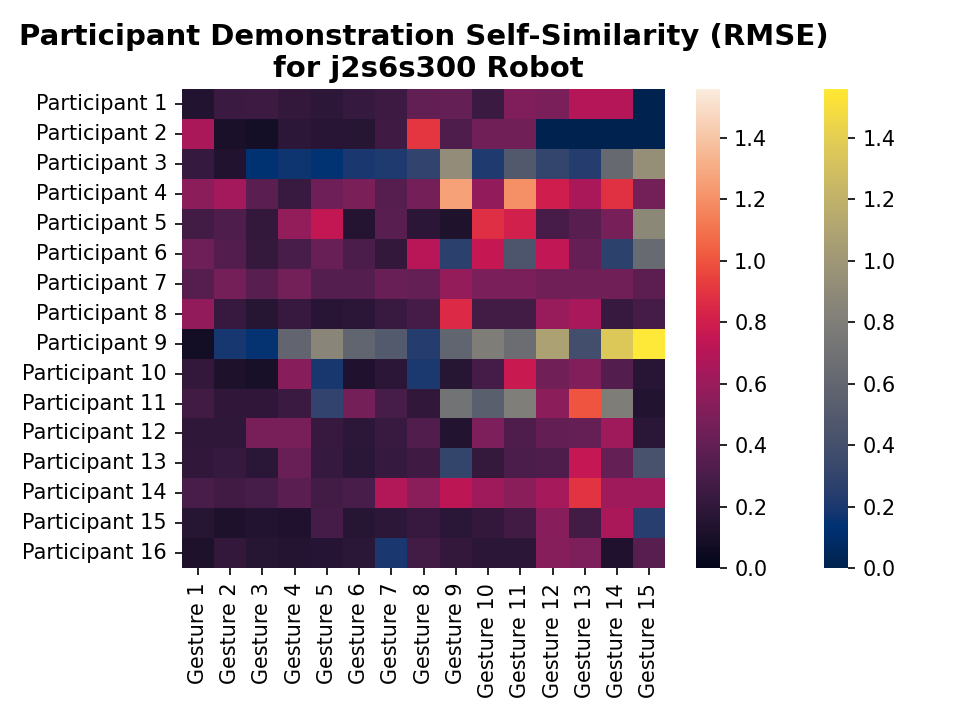

In [19]:
plt.close("all")

robot_name = "j2s6s300"
# robot_name = "Reachy"

followup = False
demo_max = 5

demo_heatmap_array, handed_array = generate_self_similarity_heat_map(robot_name,followup, demo_max)
plt.close("all")
plot_heatmap(robot_name, followup, demo_heatmap_array, handed_array, self=True)


In [3]:
"""Cross-correlation matrix:

Generate one cross-correlation graph per gesture, per robot, comparing all participants to each other.
Each participant does 5 demos, so that means 5x5 pairwise demo comparisons. Average the RMSE (should 
be legitimate; the lengths of the trajectories are almost the same). Each pairwise comparison of demos 
needs to be both temporally and spatially aligned. (Other analyses with only temporal or only spatial
alignment are also interesting, showing where participants chose similar motions with different rates
of speed, or similar motions but with different levels of enthusiasm. But for now, do all of it. The
order of operations is as follows:

1) For each robot and gesture, load two participants (go through all pairs)
2) For each pair, go through all pairs of demos
3) Figure out which hand is being used. Compare only the active hands. Make a matrix of which hand is
   being used so that we can color-code this in the final plot.
4) For that hand (for each participant), align the trajectories, first spatially (with evo), then 
   temporally (with DTW)
5) Compute the similarity between demos with APE (perhaps with translation scaling, or translation 
    only?)
6) Save this into the appropriate entry in a matrix so this can be turned into a heat map with seaborn
"""
# robot_name = "j2s6s300"
robot_name = "Reachy"
followup=False
demo_max = 5
gesture = 1
participant_1 = 12
participant_2 = 13

temp_metric, is_right_hand = generate_pairwise_comparison(participant_1, participant_2,robot_name, gesture, followup, demo_max, alignment=Alignment.Spatial)
# correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max)
# plot_heatmap(robot_name, followup, correlation_array, hand_array)                
print(temp_metric)
print(is_right_hand)


0.6823602273452946
True


In [4]:
print(temp_metric)
print(is_right_hand)

0.897217338382969
True


Getting metrics for Participants 1 and 1: 
0.2748331535015133
Getting metrics for Participants 1 and 2: 
0.9437921606099715
Getting metrics for Participants 1 and 3: 
0.9223273454458466
Getting metrics for Participants 1 and 4: 
1.5624700467167068
Getting metrics for Participants 1 and 5: 
1.9791642570255021
Getting metrics for Participants 1 and 6: 
1.3315414199692799
Getting metrics for Participants 1 and 7: 
2.564970860164523
Getting metrics for Participants 1 and 8: 
0.5497069829525136
Getting metrics for Participants 1 and 9: 
2.5731281481048027
Getting metrics for Participants 1 and 10: 
2.040711969083784
Getting metrics for Participants 1 and 11: 
1.7211688581721765
Getting metrics for Participants 1 and 12: 
Gesture 1: Failed to get metrics for participant 1 demo 1, 12 demo 3.
 Retrying...
2.414376699396216
Getting metrics for Participants 1 and 13: 
2.115517048531715
Getting metrics for Participants 1 and 14: 
Gesture 1: Failed to get metrics for participant 1 demo 2, 14 demo 

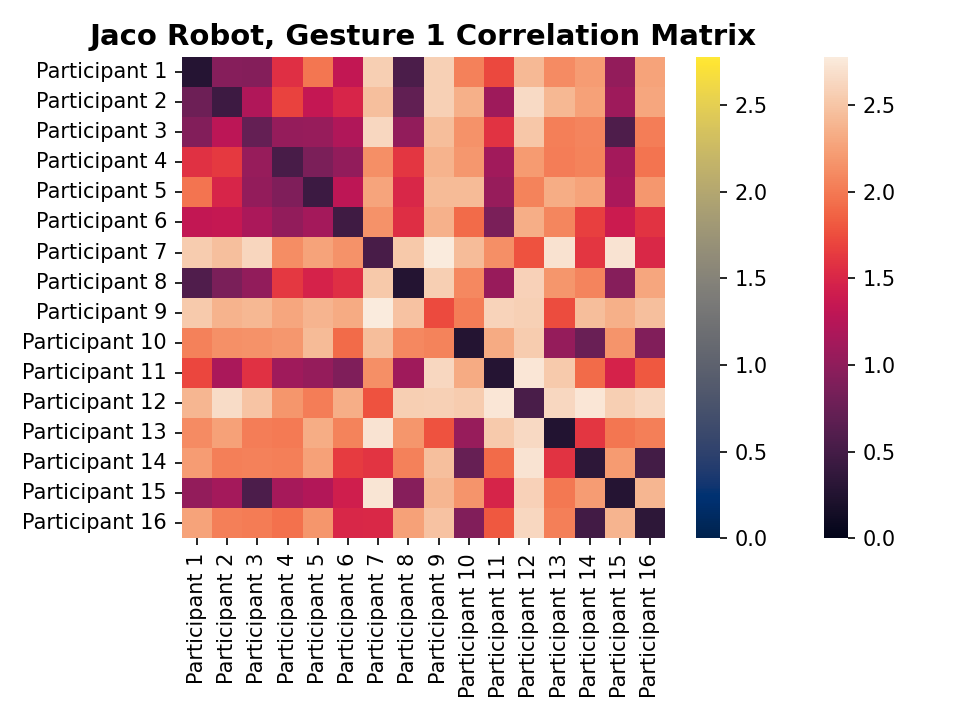

Getting metrics for Participants 1 and 1: 
Gesture 2: Failed to get metrics for participant 1 demo 5, 1 demo 4.
 Retrying...
0.42055742942917895
Getting metrics for Participants 1 and 2: 
0.612392001699879
Getting metrics for Participants 1 and 3: 
1.1068859627835281
Getting metrics for Participants 1 and 4: 
1.0013117583150148
Getting metrics for Participants 1 and 5: 
0.9652634988185165
Getting metrics for Participants 1 and 6: 
0.8154160608855046
Getting metrics for Participants 1 and 7: 
2.2997290310375895
Getting metrics for Participants 1 and 8: 
0.7082845858617042
Getting metrics for Participants 1 and 9: 
1.127300540667173
Getting metrics for Participants 1 and 10: 
2.330924996810979
Getting metrics for Participants 1 and 11: 
1.0714452910680183
Getting metrics for Participants 1 and 12: 
0.6585438385829298
Getting metrics for Participants 1 and 13: 
1.9086462896727099
Getting metrics for Participants 1 and 14: 
2.1948897017051734
Getting metrics for Participants 1 and 15: 
0.9

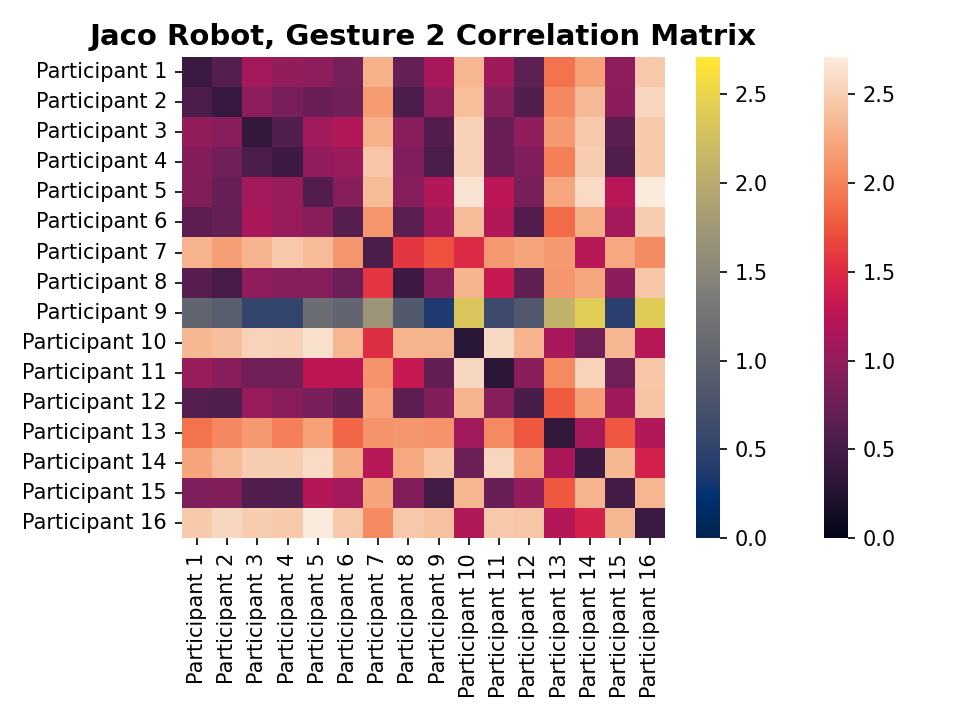

Getting metrics for Participants 1 and 1: 
0.5451686143245053
Getting metrics for Participants 1 and 2: 
0.9014365836189064
Getting metrics for Participants 1 and 3: 
1.1515035552152961
Getting metrics for Participants 1 and 4: 
1.489530559967746
Getting metrics for Participants 1 and 5: 
1.1061728704907592
Getting metrics for Participants 1 and 6: 
0.9211706114911378
Getting metrics for Participants 1 and 7: 
2.106525954202898
Getting metrics for Participants 1 and 8: 
1.1259971188018485
Getting metrics for Participants 1 and 9: 
1.3677703830145773
Getting metrics for Participants 1 and 10: 
2.3379934269106726
Getting metrics for Participants 1 and 11: 
1.2316545869996631
Getting metrics for Participants 1 and 12: 
0.8452765605168736
Getting metrics for Participants 1 and 13: 
1.9928879431994644
Getting metrics for Participants 1 and 14: 
1.9501900795147349
Getting metrics for Participants 1 and 15: 
1.1157660431758387
Getting metrics for Participants 1 and 16: 
2.3565178334062313
Get

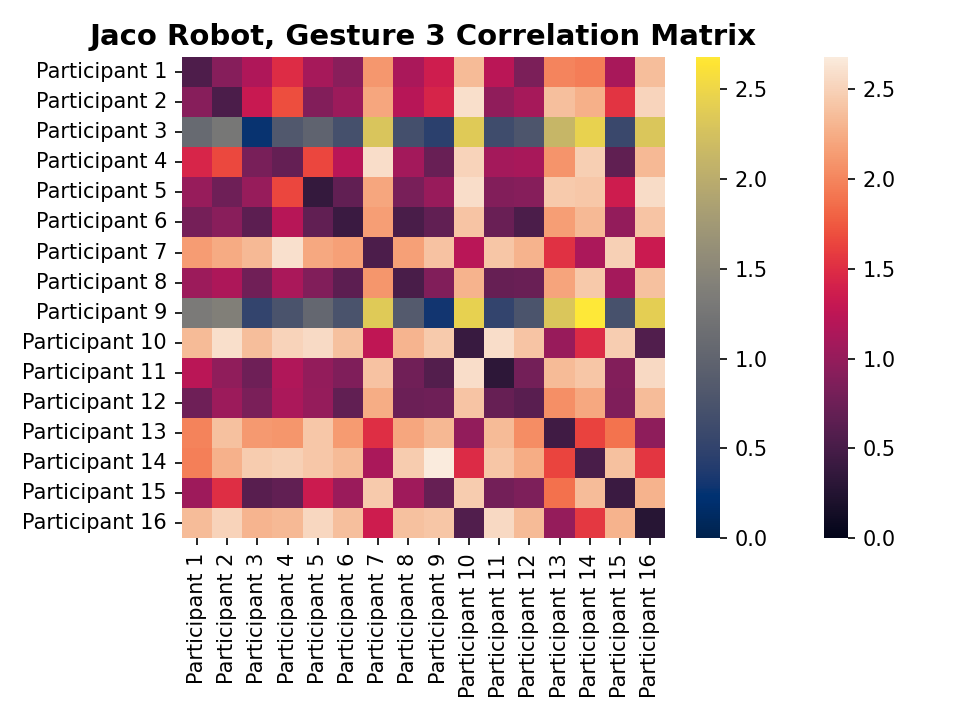

Getting metrics for Participants 1 and 1: 
0.9714943721485532
Getting metrics for Participants 1 and 2: 
1.27176094362328
Getting metrics for Participants 1 and 3: 
1.273392248107615
Getting metrics for Participants 1 and 4: 
2.6562065209763004
Getting metrics for Participants 1 and 5: 
1.968590022183874
Getting metrics for Participants 1 and 6: 
1.248973277711353
Getting metrics for Participants 1 and 7: 
1.8781594983010625
Getting metrics for Participants 1 and 8: 
1.3847308430902654
Getting metrics for Participants 1 and 9: 
1.9106184738121854
Getting metrics for Participants 1 and 10: 
2.1522531187166867
Getting metrics for Participants 1 and 11: 
1.6442302859878517
Getting metrics for Participants 1 and 12: 
2.5547314978251965
Getting metrics for Participants 1 and 13: 
1.9584732726418699
Getting metrics for Participants 1 and 14: 
2.0225919843332996
Getting metrics for Participants 1 and 15: 
1.6028485615685297
Getting metrics for Participants 1 and 16: 
1.802247130605641
Getting

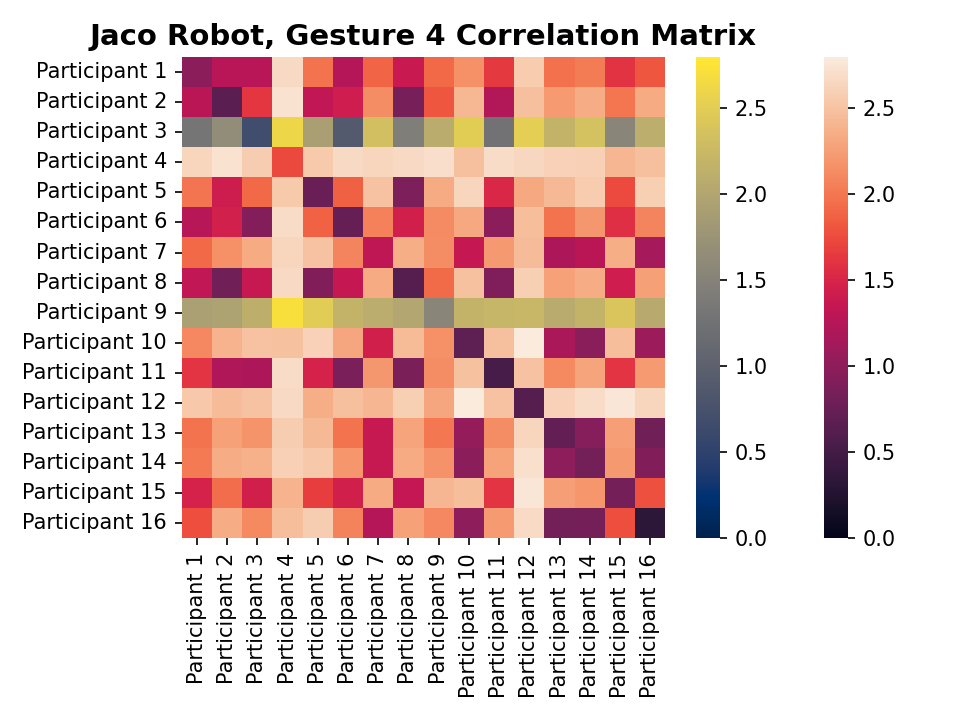

Getting metrics for Participants 1 and 1: 
0.6804600858125102
Getting metrics for Participants 1 and 2: 
1.080691686735178
Getting metrics for Participants 1 and 3: 
1.105919657656186
Getting metrics for Participants 1 and 4: 
2.0916400201985414
Getting metrics for Participants 1 and 5: 
2.2775329988292996
Getting metrics for Participants 1 and 6: 
1.1436408138892826
Getting metrics for Participants 1 and 7: 
2.059958882531605
Getting metrics for Participants 1 and 8: 
1.2432419398734873
Getting metrics for Participants 1 and 9: 
2.4718525180549884
Getting metrics for Participants 1 and 10: 
1.2091648431281827
Getting metrics for Participants 1 and 11: 
1.6643373178166516
Getting metrics for Participants 1 and 12: 
0.9403936362696242
Getting metrics for Participants 1 and 13: 
2.162326784071109
Getting metrics for Participants 1 and 14: 
1.9635334102524686
Getting metrics for Participants 1 and 15: 
2.4918535734571416
Getting metrics for Participants 1 and 16: 
2.3907657872466572
Getti

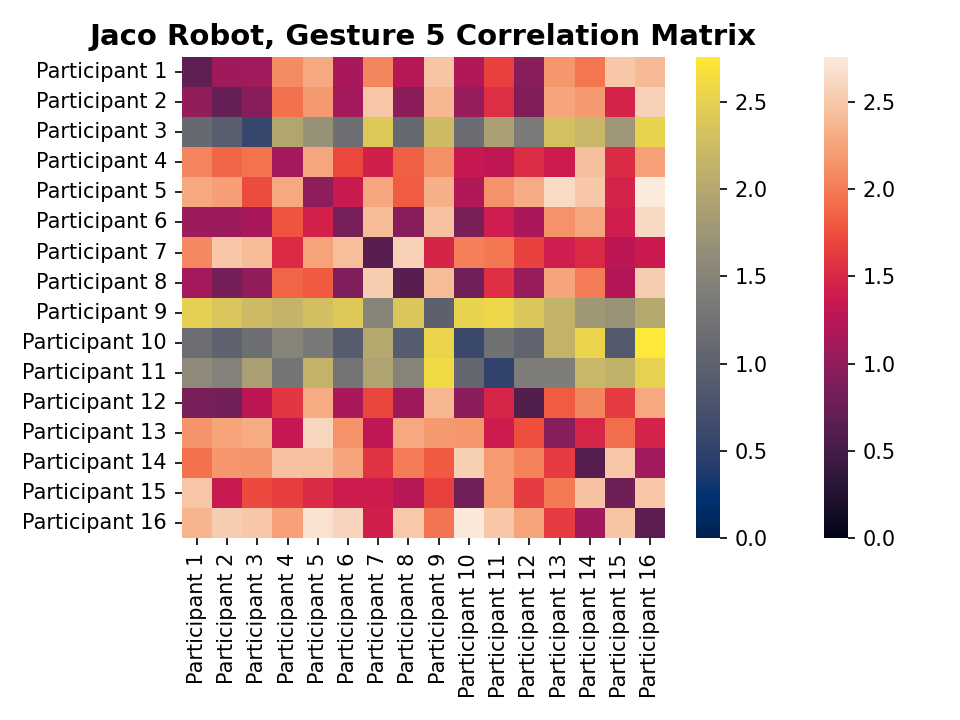

Getting metrics for Participants 1 and 1: 
1.3575925214114846
Getting metrics for Participants 1 and 2: 
1.928648738604375
Getting metrics for Participants 1 and 3: 
1.5926184935349894
Getting metrics for Participants 1 and 4: 
2.515473573077626
Getting metrics for Participants 1 and 5: 
Gesture 6: Failed to get metrics for participant 1 demo 1, 5 demo 4.
 Retrying...
2.0948267405048426
Getting metrics for Participants 1 and 6: 
Gesture 6: Failed to get metrics for participant 1 demo 5, 6 demo 5.
 Retrying...
2.1271865051968453
Getting metrics for Participants 1 and 7: 
2.4903089942496774
Getting metrics for Participants 1 and 8: 
2.2215002253270106
Getting metrics for Participants 1 and 9: 
2.122774877029117
Getting metrics for Participants 1 and 10: 
2.1843564895638776
Getting metrics for Participants 1 and 11: 
2.209872248762581
Getting metrics for Participants 1 and 12: 
1.9366892800995337
Getting metrics for Participants 1 and 13: 
1.9745244069876007
Getting metrics for Participan

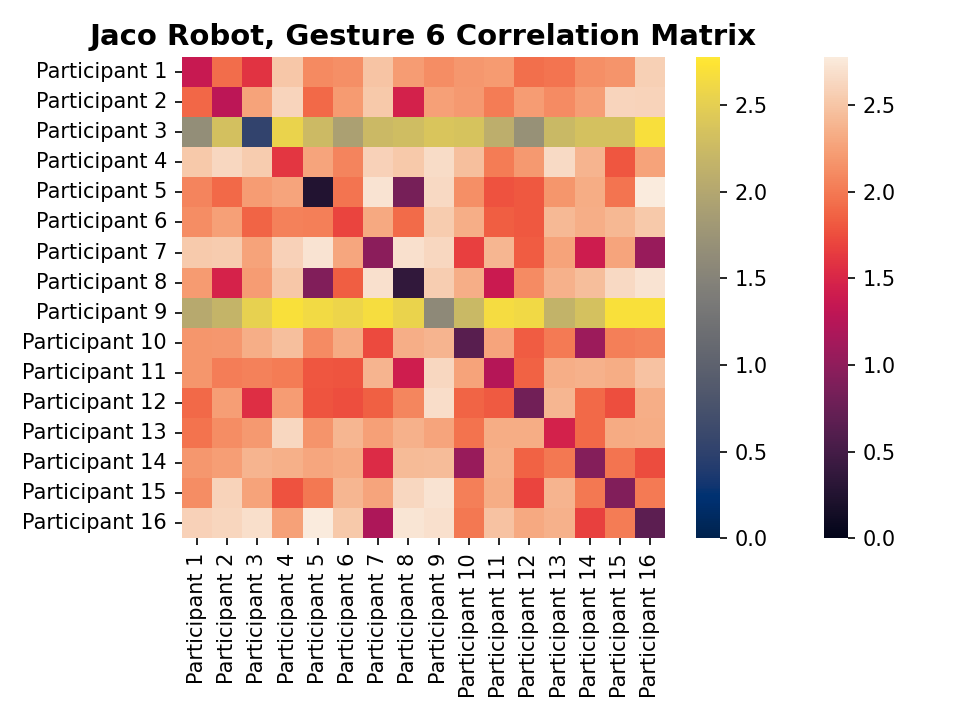

Getting metrics for Participants 1 and 1: 
0.5401037947077433
Getting metrics for Participants 1 and 2: 
0.6108816790767968
Getting metrics for Participants 1 and 3: 
0.7461518803229948
Getting metrics for Participants 1 and 4: 
1.0997924255841798
Getting metrics for Participants 1 and 5: 
1.3553924699939253
Getting metrics for Participants 1 and 6: 
0.7598126999399796
Getting metrics for Participants 1 and 7: 
2.5838913105664956
Getting metrics for Participants 1 and 8: 
0.8233621288105302
Getting metrics for Participants 1 and 9: 
1.7551980209437932
Getting metrics for Participants 1 and 10: 
2.383692793398288
Getting metrics for Participants 1 and 11: 
2.0804285371897278
Getting metrics for Participants 1 and 12: 
0.7567911546145399
Getting metrics for Participants 1 and 13: 
2.0625828364741245
Getting metrics for Participants 1 and 14: 
2.195071676845995
Getting metrics for Participants 1 and 15: 
0.8674677831355421
Getting metrics for Participants 1 and 16: 
2.6559651955598738
Get

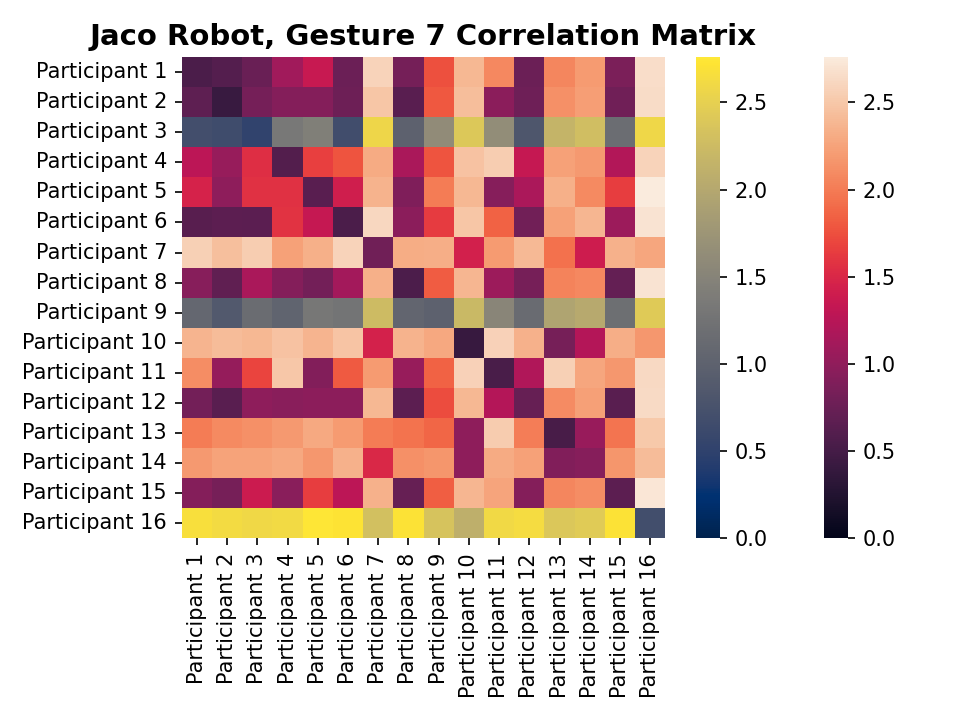

Getting metrics for Participants 1 and 1: 
0.44415879818363124
Getting metrics for Participants 1 and 2: 
1.2024112502196043
Getting metrics for Participants 1 and 3: 
0.7309570756009656
Getting metrics for Participants 1 and 4: 
2.003966067086208
Getting metrics for Participants 1 and 5: 
2.501758633364507
Getting metrics for Participants 1 and 6: 
1.4618940128406115
Getting metrics for Participants 1 and 7: 
Gesture 8: Failed to get metrics for participant 1 demo 2, 7 demo 5.
 Retrying...
2.6525836511603536
Getting metrics for Participants 1 and 8: 
1.3921380116465816
Getting metrics for Participants 1 and 9: 
1.7006701265639677
Getting metrics for Participants 1 and 10: 
2.5860652207087016
Getting metrics for Participants 1 and 11: 
Gesture 8: Failed to get metrics for participant 1 demo 5, 11 demo 4.
 Retrying...
1.8162958545363221
Getting metrics for Participants 1 and 12: 
0.8552763816368889
Getting metrics for Participants 1 and 13: 
2.0859536985858402
Getting metrics for Partic

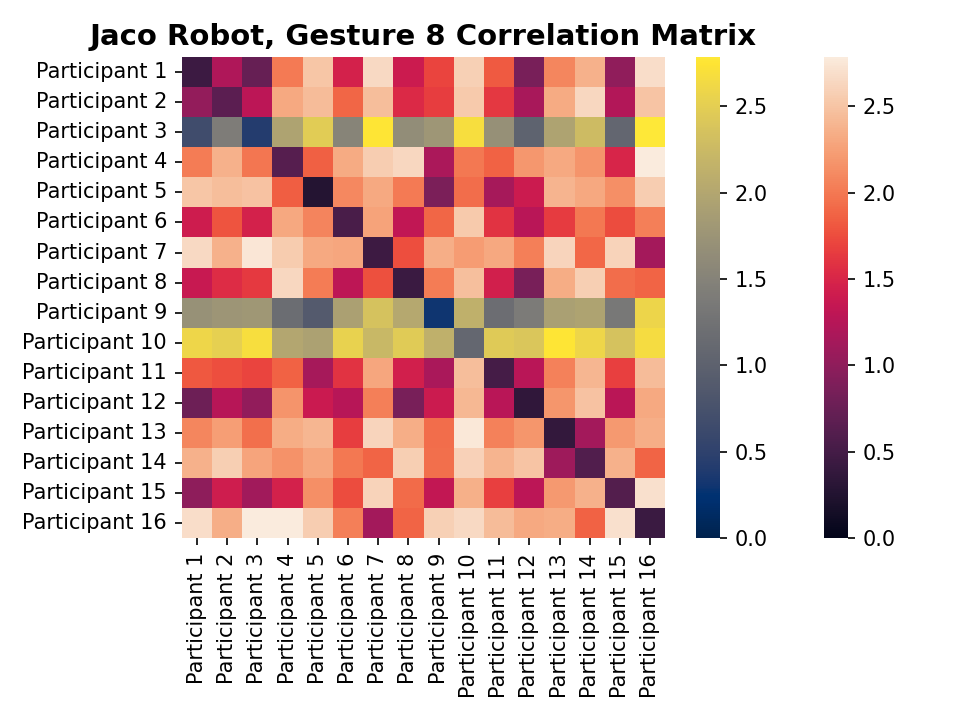

Getting metrics for Participants 1 and 1: 
0.41575494663339396
Getting metrics for Participants 1 and 2: 
0.6024500784568301
Getting metrics for Participants 1 and 3: 
1.5727741728100788
Getting metrics for Participants 1 and 4: 
1.7944769745442548
Getting metrics for Participants 1 and 5: 
2.5516404865287132
Getting metrics for Participants 1 and 6: 
2.105750907431119
Getting metrics for Participants 1 and 7: 
2.332240644507335
Getting metrics for Participants 1 and 8: 
0.9661389492905712
Getting metrics for Participants 1 and 9: 
1.489203496453755
Getting metrics for Participants 1 and 10: 
2.285622305236
Getting metrics for Participants 1 and 11: 
2.019255009265433
Getting metrics for Participants 1 and 12: 
1.2028033327465513
Getting metrics for Participants 1 and 13: 
1.9045396694985672
Getting metrics for Participants 1 and 14: 
2.237303675063369
Getting metrics for Participants 1 and 15: 
0.7734429401482372
Getting metrics for Participants 1 and 16: 
2.2734628042855336
Getting m

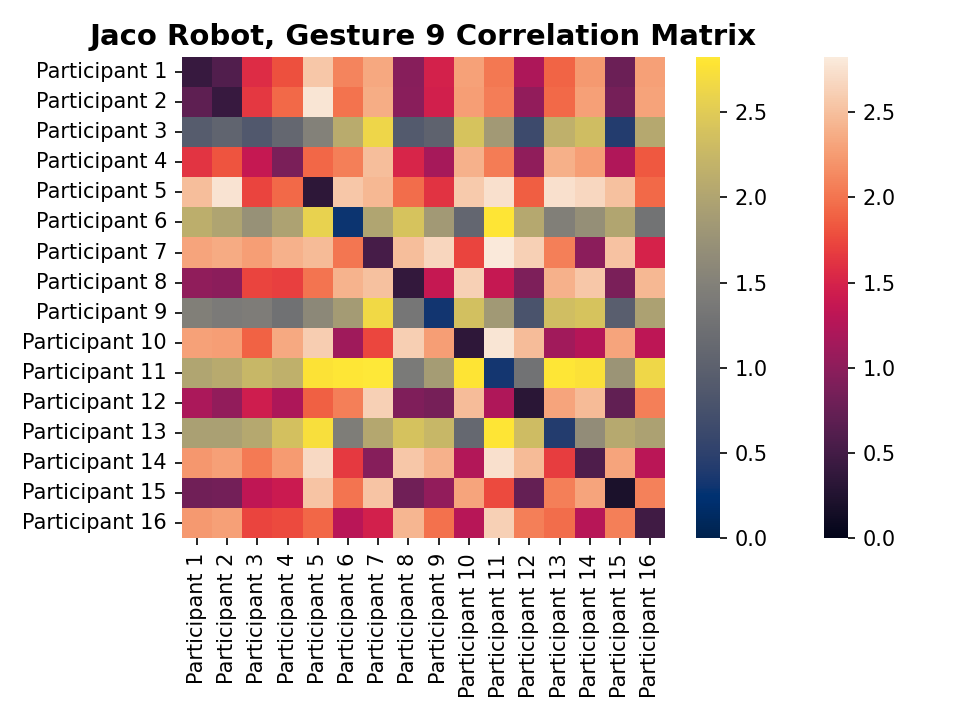

Getting metrics for Participants 1 and 1: 
0.3412065369652275
Getting metrics for Participants 1 and 2: 
0.8808178222863577
Getting metrics for Participants 1 and 3: 
0.8918013801326456
Getting metrics for Participants 1 and 4: 
1.339879778583867
Getting metrics for Participants 1 and 5: 
1.5343702163359436
Getting metrics for Participants 1 and 6: 
1.2399425906936004
Getting metrics for Participants 1 and 7: 
2.0105239821109353
Getting metrics for Participants 1 and 8: 
0.8495529856352296
Getting metrics for Participants 1 and 9: 
1.9085463618018104
Getting metrics for Participants 1 and 10: 
2.2742707758228473
Getting metrics for Participants 1 and 11: 
1.0896939278741602
Getting metrics for Participants 1 and 12: 
1.0501763665507677
Getting metrics for Participants 1 and 13: 
2.26123024946309
Getting metrics for Participants 1 and 14: 
2.038820271422445
Getting metrics for Participants 1 and 15: 
0.8737383949259165
Getting metrics for Participants 1 and 16: 
2.313346209367688
Gettin

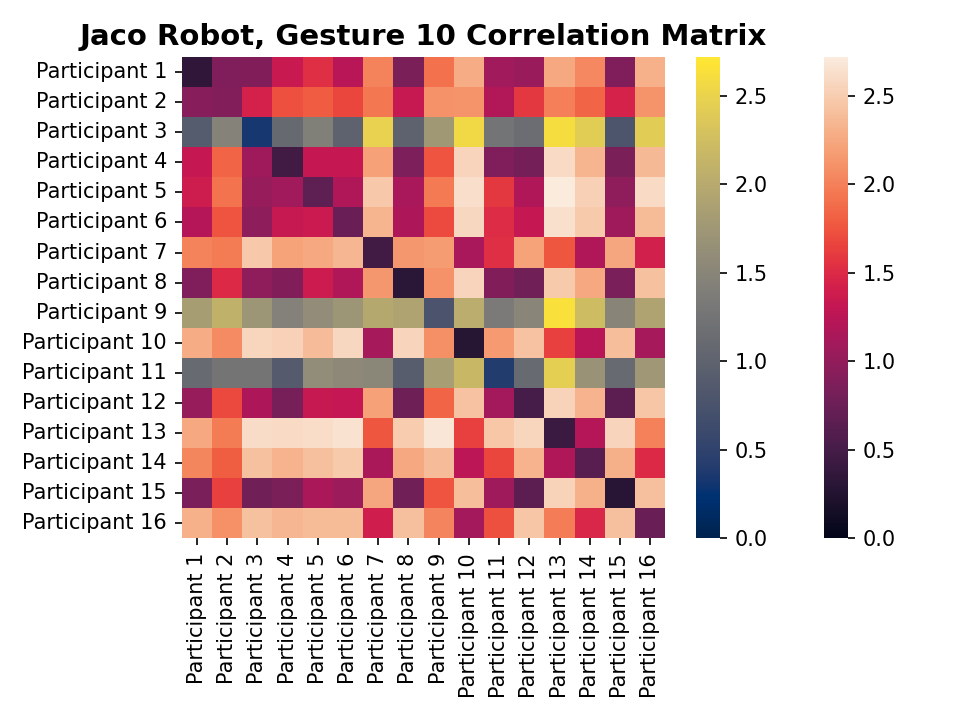

Getting metrics for Participants 1 and 1: 
0.5967207613899813
Getting metrics for Participants 1 and 2: 
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jennifermolnar/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_27009/2425832188.py", line 20, in <module>
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
  File "/home/jennifermolnar/Documents/Projects/NonAnthroHands_User_Study/python/nah/datagraphs.py", line 211, in generate_all_cross_correlation_matrix
    str(participant_1) + " demo " +
  File "/home/jennifermolnar/Documents/Projects/NonAnthroHands_User_Study/python/nah/datagraphs.py", line 150, in generate_pairwise_comparison
  File "/home/jennifermolnar/Documents/Projects/NonAnthroHands_User_Study/python/nah/utils.py", line 133, in segment_by_demo
    end_eff[i] = end_eff_data[peaks[i]:peaks[i + 1], :]
IndexError: index 4 is out of bounds for axis 0 with size 4

During handl

In [14]:
%matplotlib widget
robot_name = "Reachy"
followup=False
demo_max = 5
alignment = Alignment.SpatioTemporal

# for gesture in range(2,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(11,16):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

alignment = Alignment.Spatial
robot_name = "Reachy"
for gesture in range(1,16):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(1,16):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

alignment = Alignment.Temporal
robot_name = "Reachy"
for gesture in range(1,16):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(1,16):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)


In [ ]:
## Comparison between RH and robot end-eff
# (We'll want comparisons between the person's different demos, and the end-eff and the lh, also)

# robot_name='j2s6s300'
robot_name='Reachy'

followup = False

if followup:
    PID_max = 9
    gesture_max = 6
else: 
    PID_max = 16
    gesture_max = 15

for singlePIDval in range(1,PID_max+1):
    for gesture_num in range(1,gesture_max+1):
        end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)

        demo_max=5
        end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
        # for i in range(0,5):
        #     plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

        for demo_num in range(0,5):
            end_eff_traj = get_evo_trajectory(end_eff[i])
            right_hand_traj = get_evo_trajectory(rh[i])   

            end_eff_traj, right_hand_traj = evo_sync(end_eff_traj, right_hand_traj)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            print(metric.get_all_statistics()) # Not aligned statistics
            
            right_hand_traj = align(right_hand_traj, end_eff_traj)

            end_eff_aligned = convert_evo_to_np(end_eff_traj, end_eff[i].shape)
            # print(end_eff_aligned.shape)
            
            rh_aligned = convert_evo_to_np(right_hand_traj, rh[i].shape)
            # print(rh_aligned.shape)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            metric.get_all_statistics() #Aligned statistics

In [ ]:
## Comparison between RH demos
# (We'll want comparisons between the person's different demos (both RH and LH, depending), and the end-eff and the hands, also)

# robot_name='j2s6s300'
robot_name='Reachy'

followup = False
demo_max = 5

if followup:
    PID_max = 9
    gesture_max = 6
else: 
    PID_max = 16
    gesture_max = 15


for singlePIDval in range(1,PID_max+1):
# for singlePIDval in range(1,2):    
    for gesture_num in range(1,gesture_max+1):
    # for gesture_num in range(1,2):
        end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)

        end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
        # for i in range(0,5):
        #     plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

        demo_similarity = np.zeros([4,4,3])

        print("PID "+str(singlePIDval)+", gesture "+str(gesture_num))
        for demo_num1 in range(0,demo_max-1):
            for demo_num2 in range(demo_num1+1,demo_max):
                # print("PID "+str(singlePIDval)+", gesture "+str(gesture_num)+", demos "+str(demo_num1)+","+str(demo_num2))
                metrics1 = get_evo_metrics(rh[demo_num1],rh[demo_num2])
                # metrics2 = get_evo_metrics(rh[demo_num1],rh[demo_num2], alignment=Alignment.Spatial)
                # print(metrics1)
                # print(metrics1,metrics2)

                demo_similarity[demo_num1][demo_num2-1][0] = metrics1['rmse']
                demo_similarity[demo_num1][demo_num2-1][1] = metrics1['mean']
                demo_similarity[demo_num1][demo_num2-1][2] = metrics1['std']

        print(demo_similarity)

In [ ]:
%matplotlib widget
robot_name = "Reachy"
followup=False
demo_max = 5
alignment = Alignment.SpatioTemporal

heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Spatial
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Temporal
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)


robot_name = "j2s6s300"
alignment = Alignment.SpatioTemporal
plt.close("all")
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Spatial
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Temporal
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)


In [ ]:
# Plot both trajectories on top of each other after alignment:
plot_raw_data(5, end_eff_aligned, camera[0], rh_aligned, lh[0], joint[0])

In [ ]:
metric = evaluate_ape(end_eff_traj, right_hand_traj)
metric.get_all_statistics()